# Image-Blur 

## To blur an RGB image by a specified blur_size using Parallel code

### Before getting started, download this [this](https://homepages.cae.wisc.edu/~ece533/images/tulips.png) image and upload it to colab or any other image may also be uploaded. It might be required to make image size small in case the GPU runs out of dynamic memory

In [1]:
using Pkg
Pkg.add("CuArrays")
Pkg.add("CUDAnative")
Pkg.add("CUDAdrv")
Pkg.add("StaticArrays")
Pkg.add("BenchmarkTools")
Pkg.add("Test")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
  [be33ccc6] + CUDAnative v2.2.0
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
  [c5f51814] + CUDAdrv v3.0.1
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
  [90137ffa] + StaticArrays v0.11.0
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
 Installed BenchmarkTools ─ v0.4.2
  Updating `~/.julia/environments/v1.0/Project.toml`
  [6e4b80f9] + BenchmarkTools v0.4.2
 

In [0]:
using CUDAnative, CUDAdrv, CuArrays, StaticArrays, BenchmarkTools, Test

In [3]:
import Pkg
Pkg.add("Images")
Pkg.add("TestImages")
Pkg.add("Colors")
Pkg.add("FileIO")
Pkg.add("ImageMagick")

 Resolving package versions...
 Installed PaddedViews ─────────────── v0.4.2
 Installed TiledIteration ──────────── v0.2.3
 Installed CoordinateTransformations ─ v0.5.0
 Installed ImageMorphology ─────────── v0.2.4
 Installed ImageDistances ──────────── v0.2.4
 Installed Images ──────────────────── v0.18.0
 Installed IterTools ───────────────── v1.2.0
 Installed Colors ──────────────────── v0.9.5
 Installed FixedPointNumbers ───────── v0.6.1
 Installed Ratios ──────────────────── v0.3.1
 Installed RangeArrays ─────────────── v0.3.1
 Installed AxisAlgorithms ──────────── v1.0.0
 Installed ImageMetadata ───────────── v0.7.1
 Installed FileIO ──────────────────── v1.0.7
 Installed ImageTransformations ────── v0.8.0
 Installed ComputationalResources ──── v0.3.0
 Installed SimpleTraits ────────────── v0.8.0
 Installed CatIndices ──────────────── v0.2.0
 Installed IndirectArrays ──────────── v0.5.0
 Installed URIParser ───────────────── v0.4.0
 Installed Graphics ────────────────── v0.4.0
 I

In [0]:
using Images, Colors, FileIO, Test

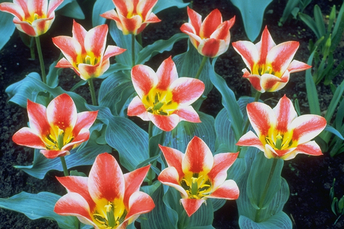

In [4]:
Img = load("/content/tulips.png")

In [5]:
summary(Img)

"229×344 Array{RGB{N0f8},2} with eltype RGB{Normed{UInt8,8}}"

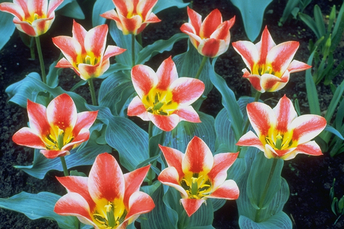

In [6]:
RGB_image = convert(Array{RGB{Float32},2},Img)

In [7]:
summary(RGB_image)

"229×344 Array{RGB{Float32},2} with eltype RGB{Float32}"

In [8]:
const height = size(RGB_image,1)
const breadth = size(RGB_image,2)
const blur_size = 5  # Increasing this would increase the degree of blurness
const channel = 3

3

In [9]:
function Image_Blur(d_inputred,d_inputgreen,d_inputblue)

  idx = (blockIdx().x - 1) * blockDim().x + threadIdx().x
  idy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
  
  blur_value = @MArray zeros(channel)
  
  # Bounds check
  if(idx <= height && idy <= breadth)
    pixels = 0
    
    for i = 1:channel     
      if(i==1)
        channel_input=d_inputred
      elseif(i==2)
        channel_input=d_inputgreen
      else
        channel_input=d_inputblue
      end  
      for x = (idx - blur_size):(idx + blur_size)
        for y = (idy - blur_size):(idy + blur_size)
          if(x >= 1 && y >= 1 && x <= height && y <= breadth)
     
            blur_value[i] += channel_input[x,y]
            pixels += 1
        
          end
        end
      end
    end
    
     pixels/=3
     d_inputred[idx,idy] = blur_value[1]/pixels
     d_inputgreen[idx,idy] = blur_value[2]/pixels
     d_inputblue[idx,idy] = blur_value[3]/pixels
  
  end
  
  return nothing
end

Image_Blur (generic function with 1 method)

In [10]:
# Channelized view of image

ChannelRGB_image = channelview(RGB_image)

3×229×344 reinterpret(Float32, ::Array{RGB{Float32},3}):
[:, :, 1] =
 0.188235  0.2       0.239216  0.572549  …  0.160784  0.180392  0.129412
 0.34902   0.329412  0.313726  0.505882     0.227451  0.247059  0.188235
 0.282353  0.27451   0.247059  0.407843     0.247059  0.262745  0.207843

[:, :, 2] =
 0.192157  0.2       0.329412  0.745098  …  0.109804  0.12549   0.0117647
 0.32549   0.321569  0.368627  0.65098      0.172549  0.168627  0.0392157
 0.270588  0.266667  0.286275  0.568627     0.196078  0.2       0.0784314

[:, :, 3] =
 0.207843  0.2       0.45098   0.807843  …  0.121569  0.0392157  0.0117647
 0.345098  0.309804  0.466667  0.733333     0.176471  0.0588235  0.027451 
 0.282353  0.243137  0.384314  0.682353     0.211765  0.105882   0.0705882

...

[:, :, 342] =
 0.0156863  0.027451   0.0235294  …  0.0431373  0.0196078  0.027451 
 0.0392157  0.0352941  0.0352941     0.0588235  0.0313726  0.0352941
 0.0823529  0.0627451  0.0470588     0.105882   0.0666667  0.0784314

[:, :, 343]

In [11]:
# Converting to Float32 type

FltRGB_image = convert(Array{Float32},ChannelRGB_image)

3×229×344 Array{Float32,3}:
[:, :, 1] =
 0.188235  0.2       0.239216  0.572549  …  0.160784  0.180392  0.129412
 0.34902   0.329412  0.313726  0.505882     0.227451  0.247059  0.188235
 0.282353  0.27451   0.247059  0.407843     0.247059  0.262745  0.207843

[:, :, 2] =
 0.192157  0.2       0.329412  0.745098  …  0.109804  0.12549   0.0117647
 0.32549   0.321569  0.368627  0.65098      0.172549  0.168627  0.0392157
 0.270588  0.266667  0.286275  0.568627     0.196078  0.2       0.0784314

[:, :, 3] =
 0.207843  0.2       0.45098   0.807843  …  0.121569  0.0392157  0.0117647
 0.345098  0.309804  0.466667  0.733333     0.176471  0.0588235  0.027451 
 0.282353  0.243137  0.384314  0.682353     0.211765  0.105882   0.0705882

...

[:, :, 342] =
 0.0156863  0.027451   0.0235294  …  0.0431373  0.0196078  0.027451 
 0.0392157  0.0352941  0.0352941     0.0588235  0.0313726  0.0352941
 0.0823529  0.0627451  0.0470588     0.105882   0.0666667  0.0784314

[:, :, 343] =
 0.0156863  0.00784314  0.

In [12]:
# Allocating and copying memory from host to device

d_inputred = CuArray(FltRGB_image[:1,:,:])
d_inputgreen = CuArray(FltRGB_image[:2,:,:])
d_inputblue = CuArray(FltRGB_image[:3,:,:])

229×344 CuArray{Float32,2}:
 0.282353  0.270588   0.282353   …  0.0823529  0.105882   0.152941 
 0.27451   0.266667   0.243137      0.0627451  0.0745098  0.184314 
 0.247059  0.286275   0.384314      0.0470588  0.0823529  0.239216 
 0.407843  0.568627   0.682353      0.0470588  0.129412   0.301961 
 0.486275  0.545098   0.607843      0.0705882  0.223529   0.313726 
 0.329412  0.556863   0.631373   …  0.133333   0.313726   0.329412 
 0.290196  0.466667   0.607843      0.227451   0.372549   0.345098 
 0.305882  0.34902    0.4           0.329412   0.392157   0.360784 
 0.301961  0.286275   0.298039      0.396078   0.403922   0.368627 
 0.454902  0.321569   0.294118      0.423529   0.407843   0.368627 
 0.552941  0.533333   0.501961   …  0.439216   0.407843   0.360784 
 0.4       0.443137   0.521569      0.439216   0.396078   0.333333 
 0.45098   0.427451   0.423529      0.431373   0.360784   0.231373 
 ⋮                               ⋱                                 
 0.180392  0.156863 

In [0]:
@cuda blocks = (Int(ceil(height/16)),Int(ceil(breadth/16))) threads = (16,16) Image_Blur(d_inputred,d_inputgreen,d_inputblue)

In [14]:
h_output = zeros(3,height,breadth)
h_output[:1,:,:] = Array(d_inputred)
h_output[:2,:,:] = Array(d_inputgreen)
h_output[:3,:,:] = Array(d_inputblue)

229×344 Array{Float32,2}:
 0.458824  0.468627  0.490481  0.499941  …  0.0928306  0.112512  0.118954
 0.469374  0.480032  0.496833  0.505379     0.100639   0.12533   0.133333
 0.45768   0.469398  0.484647  0.494601     0.107572   0.135784  0.145098
 0.440087  0.451292  0.47344   0.484663     0.115593   0.146779  0.157879
 0.428562  0.437983  0.462446  0.474703     0.124513   0.157815  0.17085 
 0.440642  0.448434  0.466739  0.478117  …  0.135596   0.169595  0.183898
 0.466132  0.476547  0.494685  0.502281     0.156091   0.192157  0.207368
 0.48265   0.494118  0.510504  0.515173     0.179644   0.216399  0.232442
 0.487938  0.497224  0.506645  0.510443     0.200978   0.237331  0.255615
 0.47546   0.483422  0.489035  0.493623     0.220979   0.255717  0.276768
 0.464528  0.470486  0.475594  0.48084   …  0.241273   0.272524  0.29495 
 0.453535  0.458244  0.460577  0.466232     0.256418   0.285052  0.306833
 0.447475  0.450743  0.451627  0.456953     0.269525   0.294831  0.314973
 ⋮          

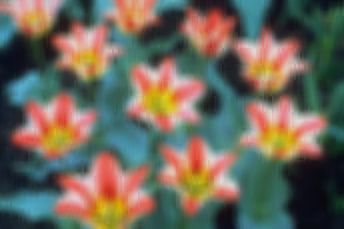

In [15]:
Blurred_image = colorview(RGB,h_output)